In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
import seaborn as sns

In [3]:
# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download ETH crypto data from Yahoo Finance using ticker 'ETH-USD'
ticker = 'ETH-USD'
data_eth = yf.download(tickers=ticker, start=start_date, end=end_date)
df_eth = pd.DataFrame(data_eth)
df_eth.reset_index(inplace=True)
df_eth.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_eth['Gold_Adj_Close'] = df_gold['Adj Close']
df_eth['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_eth = df_eth.ffill()

df_eth


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
Date,,,,,,,,
2021-04-14,2299.347900,2449.687500,2284.563721,2435.104980,2435.104980,35592822986,1734.900024,91.690002
2021-04-15,2436.034668,2544.267334,2409.924072,2519.116211,2519.116211,32325606817,1765.400024,91.669998
2021-04-16,2516.601807,2547.555664,2318.675049,2431.946533,2431.946533,36196928256,1779.000000,91.559998
2021-04-17,2429.980957,2497.385254,2333.682861,2344.895020,2344.895020,32349808978,1779.000000,91.559998
2021-04-18,2346.452393,2365.460449,2011.766846,2237.136963,2237.136963,50696368718,1779.000000,91.559998
...,...,...,...,...,...,...,...,...
2024-06-22,3516.551270,3519.497559,3477.169922,3494.813477,3494.813477,7423703673,2316.399902,105.800003
2024-06-23,3494.953857,3519.324951,3408.583008,3418.611816,3418.611816,9418141333,2316.399902,105.800003
2024-06-24,3418.783203,3430.698975,3244.241455,3350.256348,3350.256348,23137744903,2330.000000,105.470001


In [4]:
# Check for null values
df_eth.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Gold_Adj_Close       0
USIndex_Adj_Close    0
dtype: int64

In [5]:
# Check for duplicate indices
df_eth.index.duplicated(keep=False).sum()

0

In [6]:
# Stats for data
df_eth.describe()

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
count,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1.170000e+03,1170.000000,1170.000000
mean,2382.050100,2444.471951,2313.128167,2382.672392,2382.672392,1.525760e+10,1907.018373,101.403171
std,894.714121,922.907362,861.620189,894.524039,894.524039,9.999596e+09,164.134783,5.544575
min,993.400635,1073.052612,896.109009,993.636780,993.636780,2.081626e+09,1623.300049,89.639999
25%,1656.886108,1683.137970,1629.465240,1656.779053,1656.779053,8.263521e+09,1793.699951,96.290001
50%,2100.776245,2146.515625,2040.032349,2103.086426,2103.086426,1.363876e+10,1872.199951,103.120003
75%,3093.839172,3173.521362,3000.119812,3095.399109,3095.399109,1.911665e+10,1979.500000,104.885000
max,4810.071289,4891.704590,4718.039062,4812.087402,4812.087402,8.448291e+10,2433.899902,114.110001


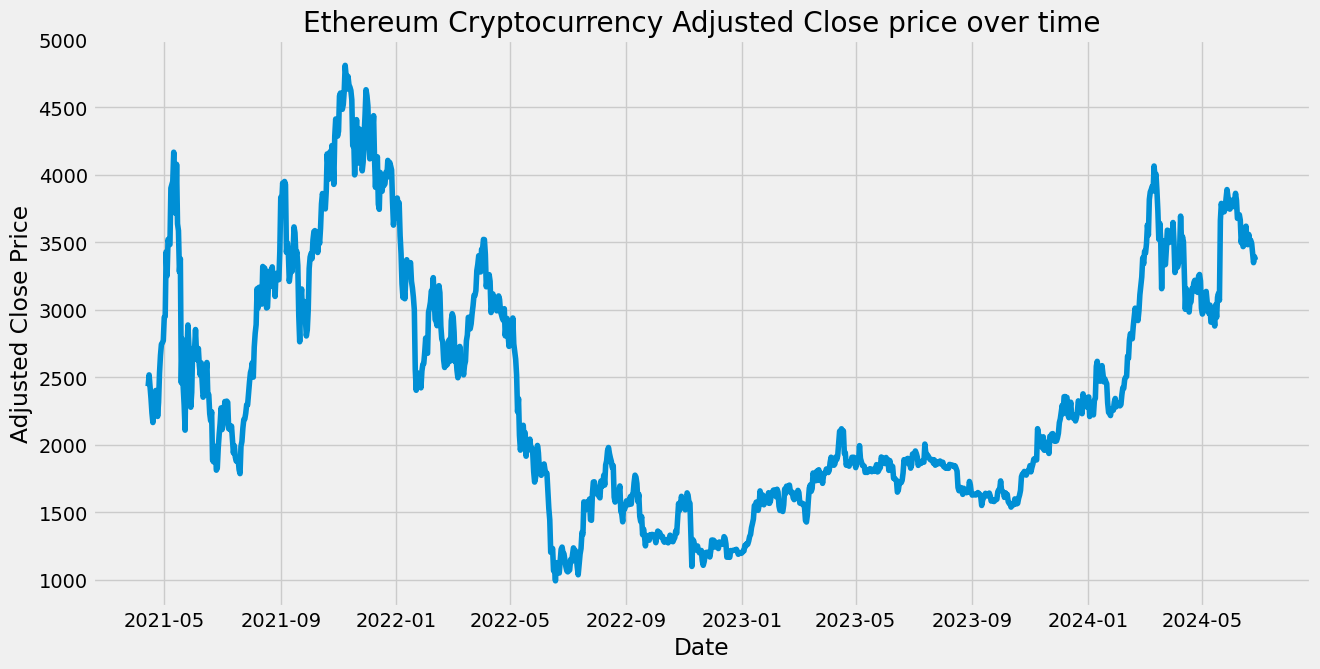

In [7]:
# Theme for plots
plt.style.use('fivethirtyeight')

# Plotting the Adjusted Close price to show the trend

plt.figure(figsize=(14,7))
plt.plot(df_eth.index, df_eth['Adj Close'])
plt.title('Ethereum Cryptocurrency Adjusted Close price over time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.show()

In [8]:
# Calculate differences between high and low prices for the stock data
df_eth['High_Low_Diff'] = df_eth['High'] - df_eth['Low']

# Calculate percentage returns and log percentage returns
df_eth['Pct_Returns'] = df_eth['Adj Close'].pct_change()
df_eth['Log_Pct_Returns'] = np.log(1 + df_eth['Pct_Returns'])

df_eth['Log_Pct_Returns_1'] = df_eth['Log_Pct_Returns'].shift(1)
df_eth.dropna(inplace=True)
df_eth

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,Log_Pct_Returns,Log_Pct_Returns_1
Date,,,,,,,,,,,,
2021-04-16,2516.601807,2547.555664,2318.675049,2431.946533,2431.946533,36196928256,1779.000000,91.559998,228.880615,-0.034603,-0.035216,0.033918
2021-04-17,2429.980957,2497.385254,2333.682861,2344.895020,2344.895020,32349808978,1779.000000,91.559998,163.702393,-0.035795,-0.036451,-0.035216
2021-04-18,2346.452393,2365.460449,2011.766846,2237.136963,2237.136963,50696368718,1779.000000,91.559998,353.693604,-0.045954,-0.047044,-0.036451
2021-04-19,2238.032715,2276.776855,2086.688721,2166.188721,2166.188721,34060654971,1769.400024,91.070000,190.088135,-0.031714,-0.032228,-0.047044
2021-04-20,2161.939453,2345.834961,2060.143799,2330.210938,2330.210938,39433483315,1777.300049,91.239998,285.691162,0.075719,0.072990,-0.032228
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-22,3516.551270,3519.497559,3477.169922,3494.813477,3494.813477,7423703673,2316.399902,105.800003,42.327637,-0.006047,-0.006065,0.001420
2024-06-23,3494.953857,3519.324951,3408.583008,3418.611816,3418.611816,9418141333,2316.399902,105.800003,110.741943,-0.021804,-0.022045,-0.006065
2024-06-24,3418.783203,3430.698975,3244.241455,3350.256348,3350.256348,23137744903,2330.000000,105.470001,186.457520,-0.019995,-0.020198,-0.022045


##### Technical Indicators

In [9]:
# Moving Averages

# Simple Moving Averages
df_eth['SMA_5'] = df_eth['Adj Close'].rolling(window=5).mean()
df_eth['SMA_10'] = df_eth['Adj Close'].rolling(window=10).mean()
df_eth['SMA_20'] = df_eth['Adj Close'].rolling(window=20).mean()
df_eth['SMA_50'] = df_eth['Adj Close'].rolling(window=50).mean()
df_eth['SMA_100'] = df_eth['Adj Close'].rolling(window=100).mean()

# Exponential Moving Averages
df_eth['EMA_50'] = df_eth['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_eth['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_eth['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_eth['MACD'] = df_eth['Adj Close'].ewm(span=12, adjust=False).mean() - df_eth['Adj Close'].ewm(span=26, adjust=False).mean()
df_eth['MACD_Signal'] = df_eth['MACD'].ewm(span=9, adjust=False).mean()
df_eth['MACD_Hist'] = df_eth['MACD'] - df_eth['MACD_Signal']

# Bollinger Bands
df_eth['BB_Upper'] = df_eth['SMA_20'] + 2*df_eth['Adj Close'].rolling(window=20).std()
df_eth['BB_Lower'] = df_eth['SMA_20'] - 2*df_eth['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_eth['14-high'] = df_eth['High'].rolling(14).max()
df_eth['14-low'] = df_eth['Low'].rolling(14).min()
df_eth['%K'] = (df_eth['Adj Close'] - df_eth['14-low']) * 100 / (df_eth['14-high'] - df_eth['14-low'])
df_eth['%D'] = df_eth['%K'].rolling(3).mean()

# Average True Range (ATR)
df_eth['H-L'] = df_eth['High'] - df_eth['Low']
df_eth['H-PC'] = np.abs(df_eth['High'] - df_eth['Adj Close'].shift(1))
df_eth['L-PC'] = np.abs(df_eth['Low'] - df_eth['Adj Close'].shift(1))
df_eth['TR'] = df_eth[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_eth['ATR'] = df_eth['TR'].rolling(14).mean()

df_eth

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,BB_Lower,14-high,14-low,%K,%D,H-L,H-PC,L-PC,TR,ATR
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-16,2516.601807,2547.555664,2318.675049,2431.946533,2431.946533,36196928256,1779.000000,91.559998,228.880615,-0.034603,...,NaN,NaN,NaN,NaN,NaN,228.880615,NaN,NaN,228.880615,NaN
2021-04-17,2429.980957,2497.385254,2333.682861,2344.895020,2344.895020,32349808978,1779.000000,91.559998,163.702393,-0.035795,...,NaN,NaN,NaN,NaN,NaN,163.702393,65.438721,98.263672,163.702393,NaN
2021-04-18,2346.452393,2365.460449,2011.766846,2237.136963,2237.136963,50696368718,1779.000000,91.559998,353.693604,-0.045954,...,NaN,NaN,NaN,NaN,NaN,353.693604,20.565430,333.128174,353.693604,NaN
2021-04-19,2238.032715,2276.776855,2086.688721,2166.188721,2166.188721,34060654971,1769.400024,91.070000,190.088135,-0.031714,...,NaN,NaN,NaN,NaN,NaN,190.088135,39.639893,150.448242,190.088135,NaN
2021-04-20,2161.939453,2345.834961,2060.143799,2330.210938,2330.210938,39433483315,1777.300049,91.239998,285.691162,0.075719,...,NaN,NaN,NaN,NaN,NaN,285.691162,179.646240,106.044922,285.691162,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-22,3516.551270,3519.497559,3477.169922,3494.813477,3494.813477,7423703673,2316.399902,105.800003,42.327637,-0.006047,...,3358.783251,3719.367676,3366.223877,36.412815,36.507651,42.327637,3.421875,38.905762,42.327637,125.247105
2024-06-23,3494.953857,3519.324951,3408.583008,3418.611816,3418.611816,9418141333,2316.399902,105.800003,110.741943,-0.021804,...,3338.057964,3711.428711,3366.223877,15.175900,31.340789,110.741943,24.511475,86.230469,110.741943,129.496948
2024-06-24,3418.783203,3430.698975,3244.241455,3350.256348,3350.256348,23137744903,2330.000000,105.470001,186.457520,-0.019995,...,3313.995092,3669.890869,3244.241455,24.906622,25.498446,186.457520,12.087158,174.370361,186.457520,138.296474


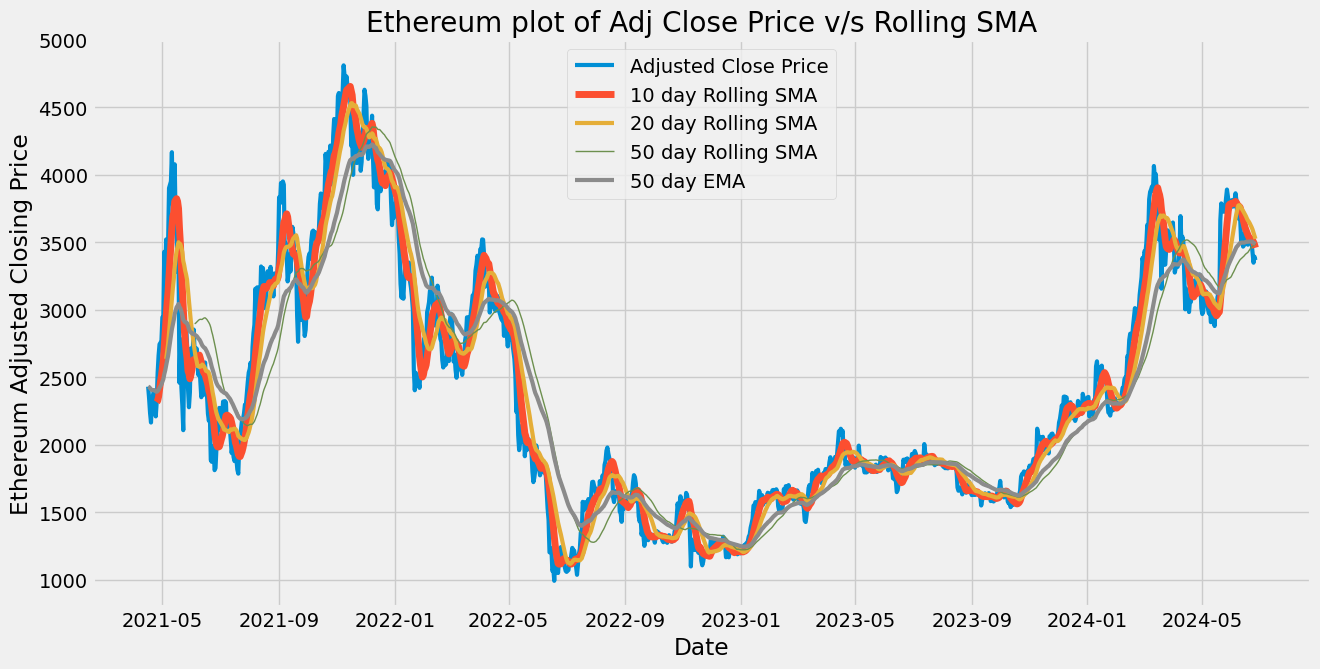

In [10]:
#Plotting 'Adj Close' Price and Rolling SMA and EMA lines
plt.figure(figsize = (14,7))
plt.plot(df_eth['Adj Close'],label='Adjusted Close Price',linewidth=3)
plt.plot(df_eth['SMA_10'],label='10 day Rolling SMA',linewidth=5)
plt.plot(df_eth['SMA_20'],label='20 day Rolling SMA',linewidth=3)
plt.plot(df_eth['SMA_50'],label='50 day Rolling SMA',linewidth=1)
plt.plot(df_eth['EMA_50'],label='50 day EMA',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Ethereum Adjusted Closing Price')
plt.title('Ethereum plot of Adj Close Price v/s Rolling SMA')
plt.legend()

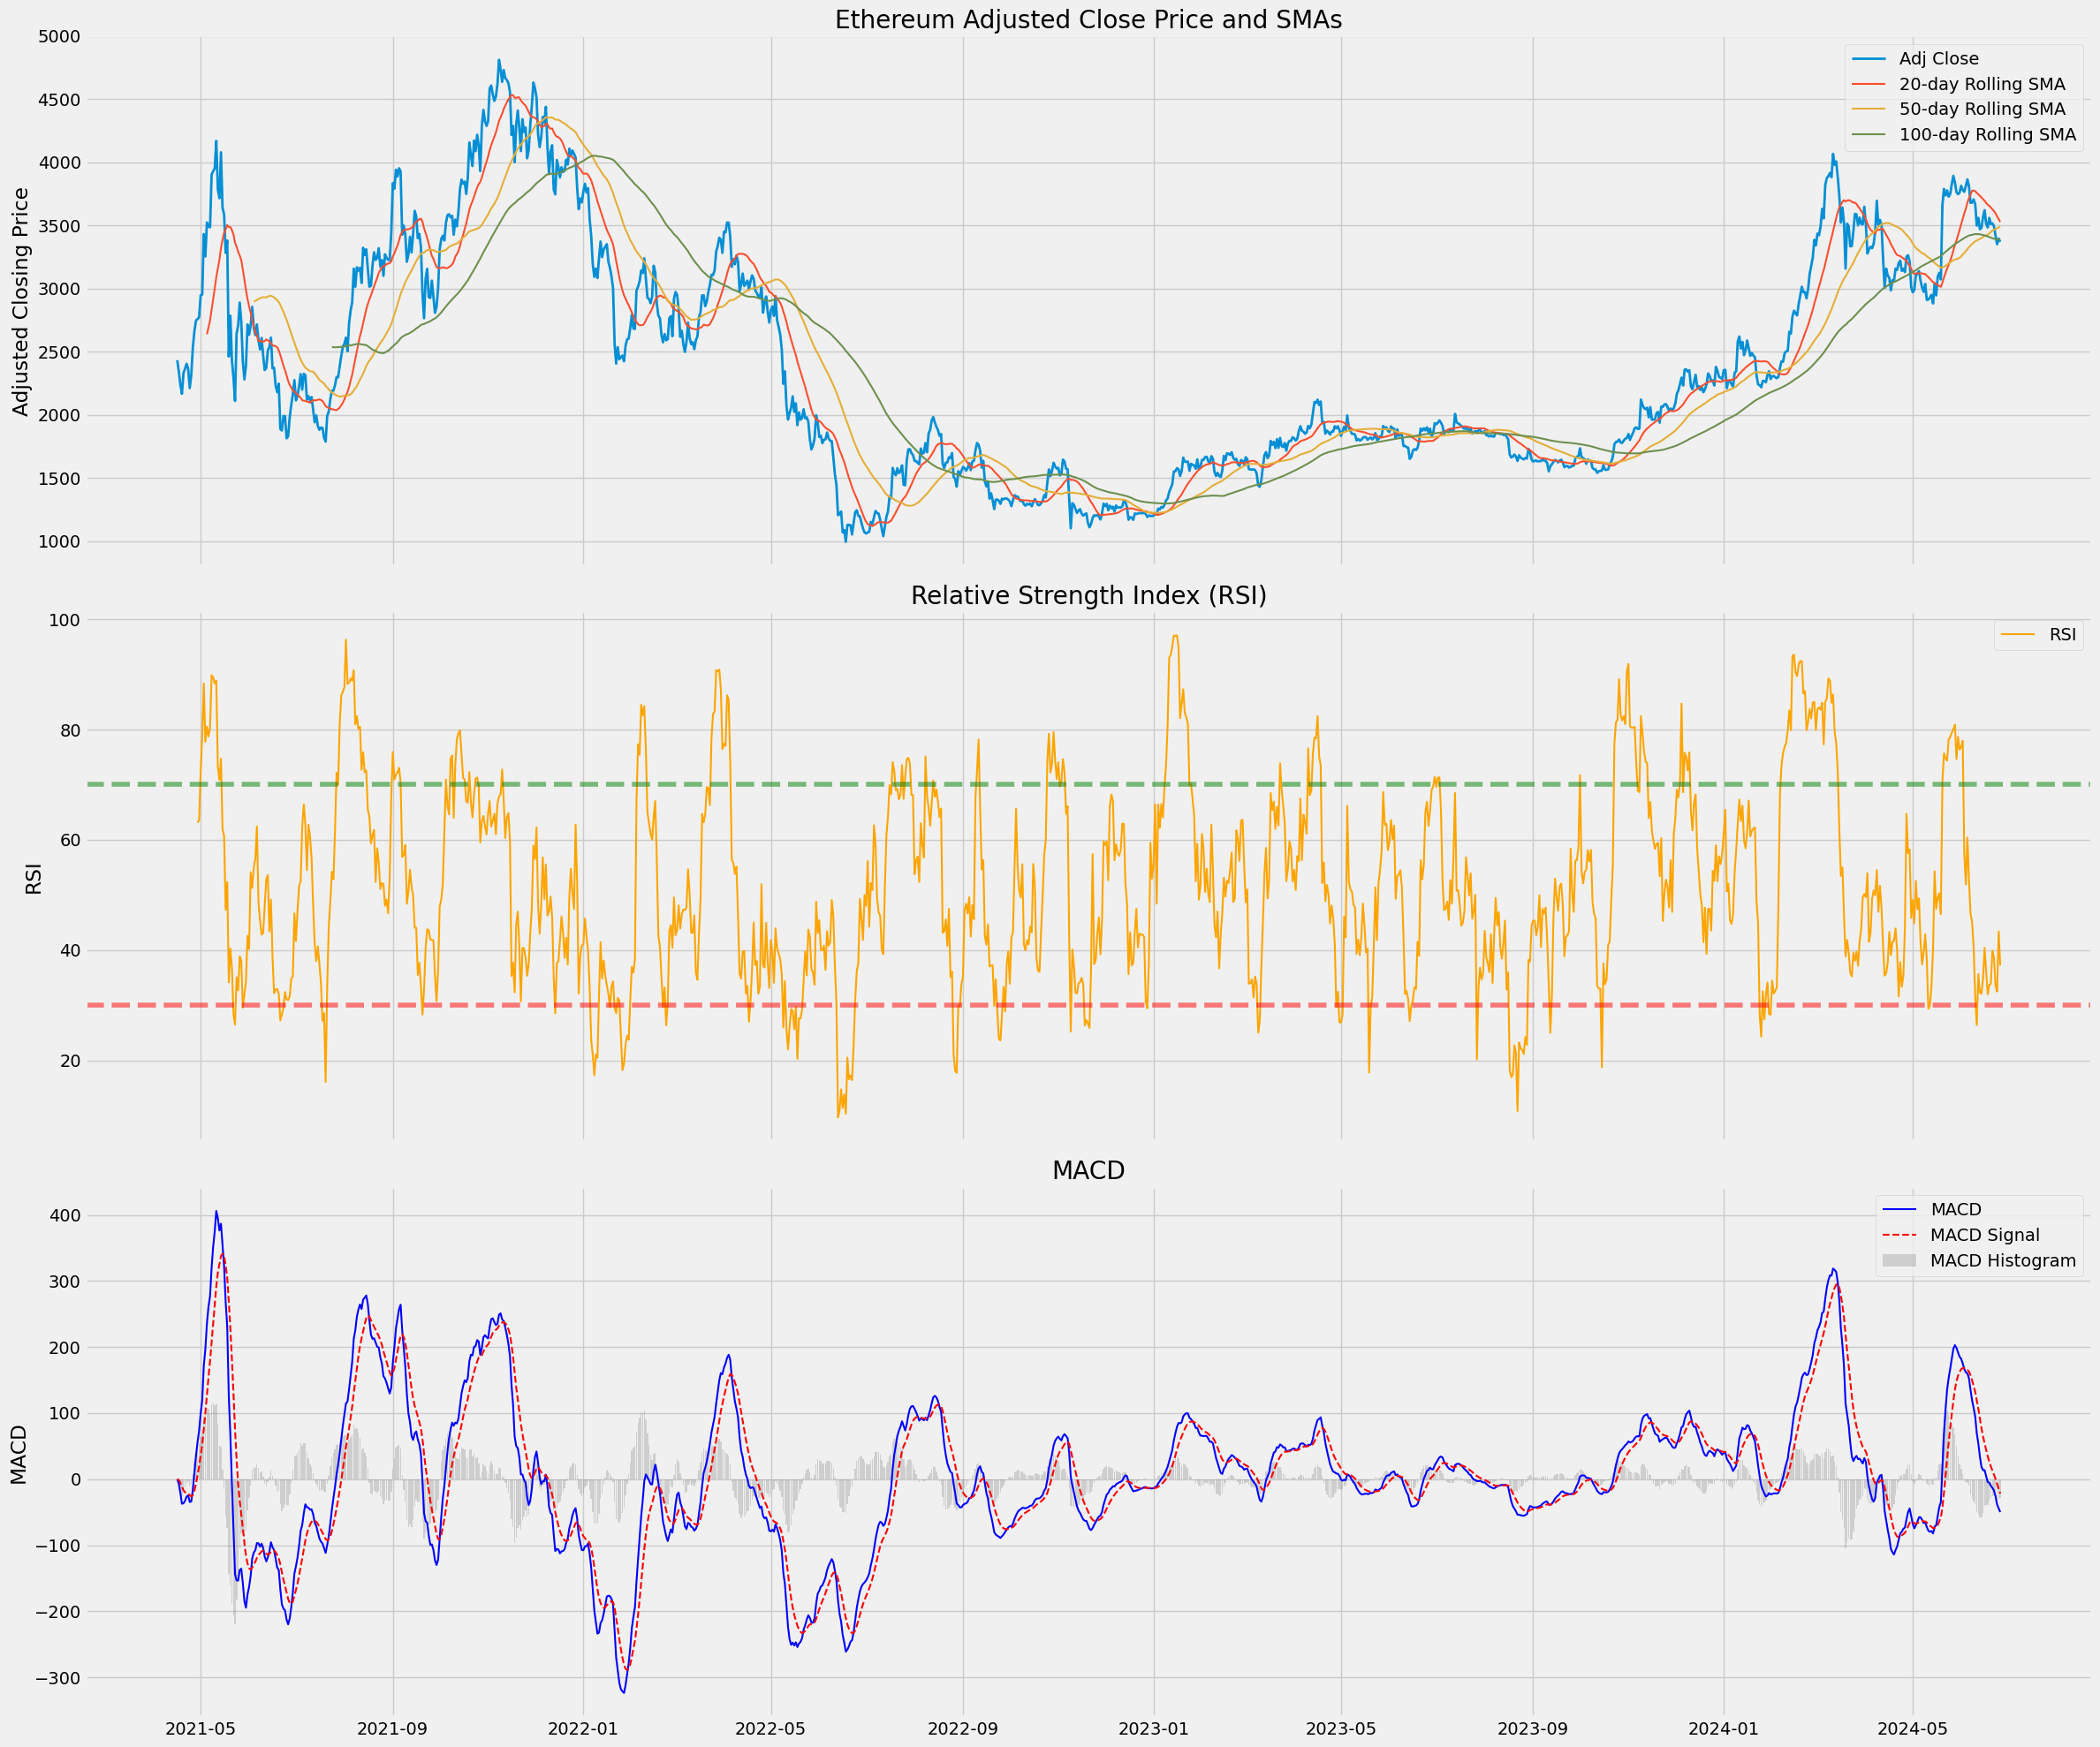

In [11]:
plt.style.use('fivethirtyeight')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 20), sharex=True)

# Plotting 'Adj Close' Price vs SMA lines on the first subplot
ax1.plot(df_eth['Adj Close'], label='Adj Close', linewidth=2)
ax1.plot(df_eth['SMA_20'], label='20-day Rolling SMA', linewidth=1.5)
ax1.plot(df_eth['SMA_50'], label='50-day Rolling SMA', linewidth=1.5)
ax1.plot(df_eth['SMA_100'], label='100-day Rolling SMA', linewidth=1.5)
ax1.set_title('Ethereum Adjusted Close Price and SMAs')
ax1.set_ylabel('Adjusted Closing Price')
ax1.legend()

# Plotting RSI on the second subplot
ax2.plot(df_eth['RSI'], label='RSI', color='orange', linewidth=1.5)
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI')
ax2.axhline(30, linestyle='--', alpha=0.5, color='red')
ax2.axhline(70, linestyle='--', alpha=0.5, color='green')
ax2.legend()

# Plotting MACD on the third subplot
ax3.plot(df_eth['MACD'], label='MACD', color='blue', linewidth=1.5)
ax3.plot(df_eth['MACD_Signal'], label='MACD Signal', color='red', linestyle='--', linewidth=1.5)
ax3.bar(df_eth.index, df_eth['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.3)
ax3.set_title('MACD')
ax3.set_ylabel('MACD')
ax3.legend()

plt.tight_layout()
plt.show()

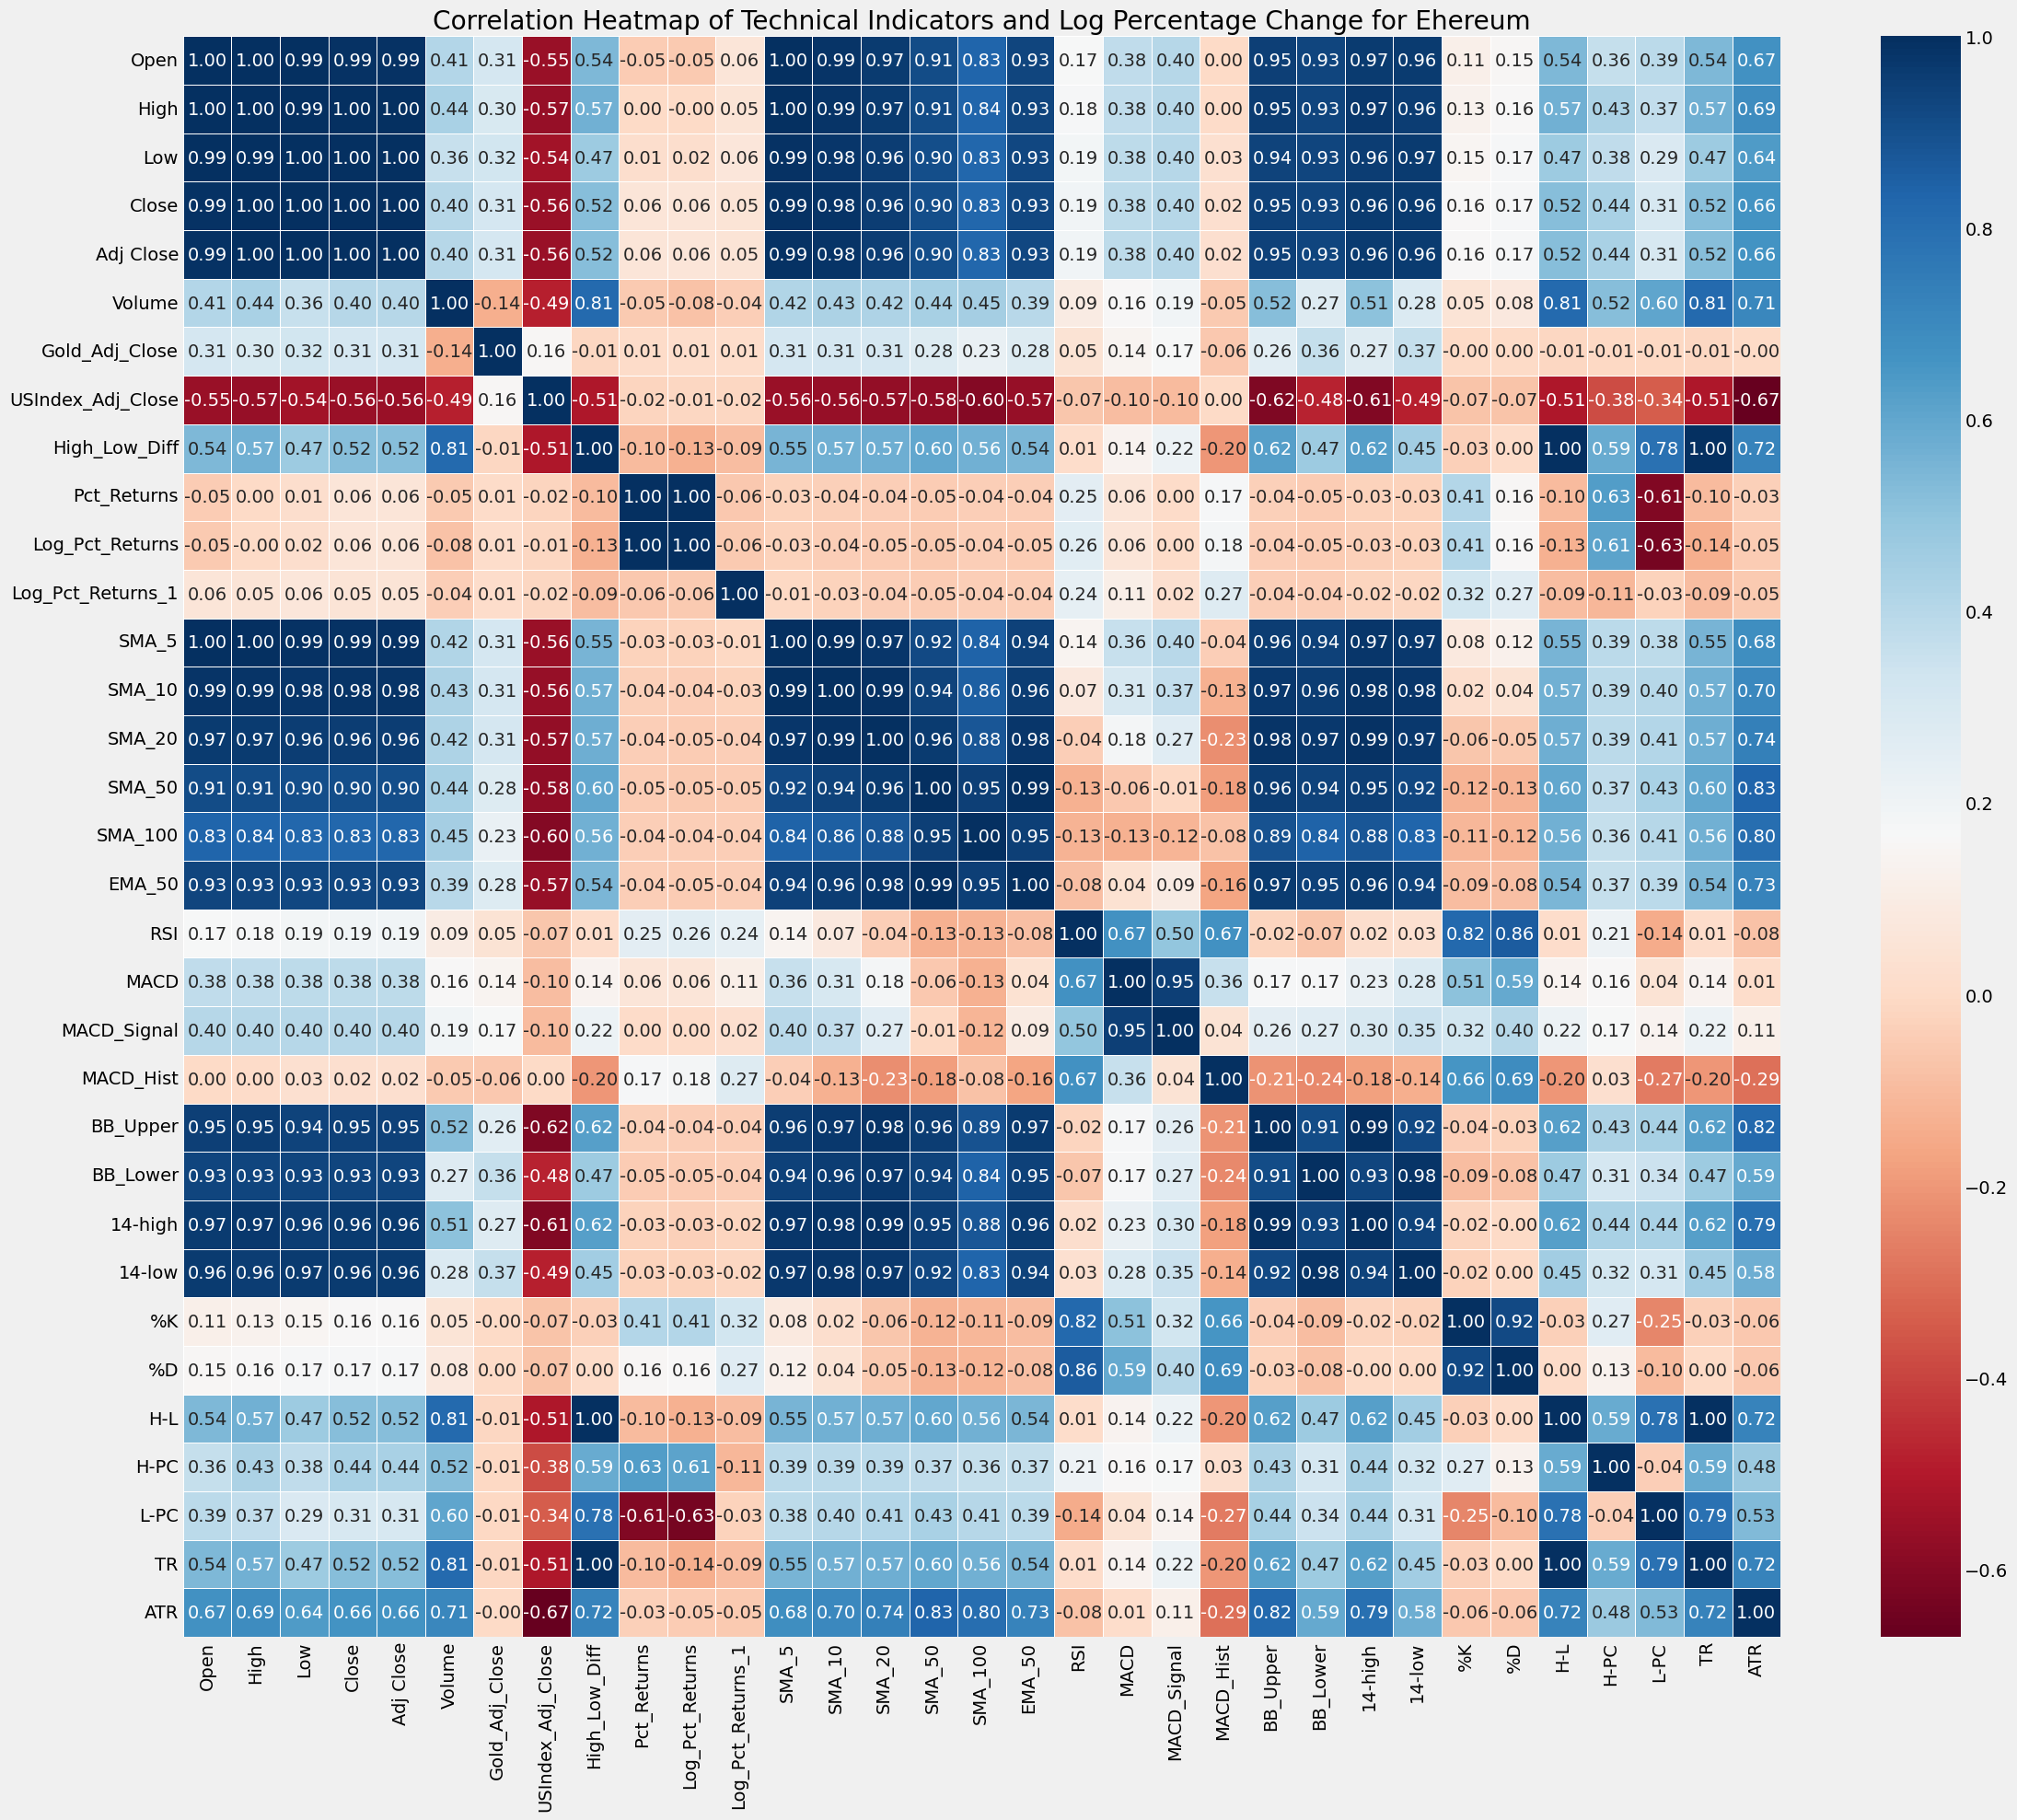

In [12]:
# Correlation between technical indiactors and log percentage change

# Compute correlation matrix
corr_matrix = df_eth.corr()

# Create a heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Technical Indicators and Log Percentage Change for Ehereum')
plt.tight_layout()
plt.show()


#### Economic Indicators

In [13]:
# Fetch Real disposable Income data(Monthly) from FRED using pandas_datareader
Real_Disp_Inc_Mon = pdr.get_data_fred('DSPIC96', start=start_date, end=end_date)
Real_Disp_Inc_df = Real_Disp_Inc_Mon.resample('D').ffill()
Real_Disp_Inc_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Real_Disp_Inc_df.index = pd.to_datetime(Real_Disp_Inc_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_eth.join(Real_Disp_Inc_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)
merged_df


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,TR,ATR,DSPIC96,FEDFUNDS,GDPC1,UNRATE,UMCSENT,CPILFESL,PPIACO,WM2NS
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-24,2123.961182,2197.649414,2107.323486,2189.218750,2189.218750,16057446601,1801.400024,92.910004,90.325928,0.030329,...,90.325928,124.029288,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20569.9
2021-07-25,2187.145508,2194.438232,2108.829834,2191.373779,2191.373779,14566483636,1801.400024,92.910004,85.608398,0.000984,...,85.608398,123.797773,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20569.9
2021-07-26,2191.309814,2428.817139,2177.329590,2233.366699,2233.366699,29614324233,1798.699951,92.650002,251.487549,0.019163,...,251.487549,130.568935,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20521.9
2021-07-27,2230.197021,2316.950195,2154.731201,2298.333496,2298.333496,23067480378,1799.500000,92.430000,162.218994,0.029089,...,162.218994,133.719169,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20521.9
2021-07-28,2302.081299,2341.777832,2250.914062,2296.545410,2296.545410,18991302378,1799.500000,92.320000,90.863770,-0.000778,...,90.863770,129.789132,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20521.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,2380.200684,2445.017578,2338.703857,2347.566162,2347.566162,15660799060,2073.899902,101.230003,106.313721,-0.013105,...,106.313721,91.589652,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5
2023-12-29,2346.843750,2386.004639,2262.975830,2300.690674,2300.690674,12536968996,2062.399902,101.330002,123.028809,-0.019968,...,123.028809,93.046735,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5
2023-12-30,2300.399658,2322.021484,2270.011963,2292.065430,2292.065430,6888195427,2062.399902,101.330002,52.009521,-0.003749,...,52.009521,93.386056,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5


In [14]:
# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Low', 'Volume',
    'High_Low_Diff', 'Gold_Adj_Close', 'USIndex_Adj_Close',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR',
    'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
    'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS'
]

# Number of lagged versions to create
num_lags = 5

# Dictionary to store the shifted columns
shifted_columns = {}

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):  
        shifted_columns[f'{column}_{lag}'] = merged_df[column].shift(lag)

# Create a DataFrame from the shifted columns
shifted_df = pd.DataFrame(shifted_columns)

# Concatenate the shifted columns to the original DataFrame
merged_df = pd.concat([merged_df, shifted_df], axis=1)

# Drop rows with any NaN values
merged_df.dropna(inplace=True)

merged_df

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,PPIACO_1,PPIACO_2,PPIACO_3,PPIACO_4,PPIACO_5,WM2NS_1,WM2NS_2,WM2NS_3,WM2NS_4,WM2NS_5
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-29,2299.011963,2396.451904,2273.404785,2380.956787,2380.956787,16313373113,1831.199951,91.860001,123.047119,0.036756,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20569.9,20569.9
2021-07-30,2382.545166,2469.704834,2322.337158,2466.961426,2466.961426,20212848934,1812.599976,92.169998,147.367676,0.036122,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20569.9
2021-07-31,2461.575684,2551.161133,2423.816162,2536.209961,2536.209961,18001710283,1812.599976,92.169998,127.344971,0.028070,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20521.9
2021-08-01,2530.462891,2695.429443,2520.931885,2561.852051,2561.852051,22697987055,1812.599976,92.169998,174.497559,0.010110,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20521.9
2021-08-02,2557.774658,2665.730957,2511.375244,2610.153320,2610.153320,22162754104,1818.099976,92.050003,154.355713,0.018854,...,233.415,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20521.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,2380.200684,2445.017578,2338.703857,2347.566162,2347.566162,15660799060,2073.899902,101.230003,106.313721,-0.013105,...,249.866,249.866,249.866,249.866,249.866,20901.5,20901.5,20901.5,20875.3,20875.3
2023-12-29,2346.843750,2386.004639,2262.975830,2300.690674,2300.690674,12536968996,2062.399902,101.330002,123.028809,-0.019968,...,249.866,249.866,249.866,249.866,249.866,20901.5,20901.5,20901.5,20901.5,20875.3
2023-12-30,2300.399658,2322.021484,2270.011963,2292.065430,2292.065430,6888195427,2062.399902,101.330002,52.009521,-0.003749,...,249.866,249.866,249.866,249.866,249.866,20901.5,20901.5,20901.5,20901.5,20901.5


#### Fitting models with all features

In [15]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2',
            'High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3', 'High_3', 'Low_3', 
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3', 
            'Volume_4', 'Open_4', 'High_4', 'Low_4', 
            'High_Low_Diff_4', 'Gold_Adj_Close_4','USIndex_Adj_Close_4', 
            'Volume_5', 'Open_5', 'High_5', 'Low_5', 
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'SMA_5_4', 'SMA_10_4', 'SMA_20_4', 'SMA_50_4','SMA_100_4',
            'EMA_50_4', 'RSI_4', 'MACD_4', 'MACD_Signal_4',
            'MACD_Hist_4', 'BB_Upper_4', 'BB_Lower_4', '%K_4', '%D_4', 'ATR_4',
            'SMA_5_5', 'SMA_10_5', 'SMA_20_5', 'SMA_50_5','SMA_100_5',
            'EMA_50_5', 'RSI_5', 'MACD_5', 'MACD_Signal_5',
            'MACD_Hist_5', 'BB_Upper_5', 'BB_Lower_5', '%K_5', '%D_5', 'ATR_5',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3',
            'DSPIC96_4', 'FEDFUNDS_4', 'GDPC1_4', 'UNRATE_4', 
            'UMCSENT_4', 'CPILFESL_4', 'PPIACO_4', 'WM2NS_4',
            'DSPIC96_5', 'FEDFUNDS_5', 'GDPC1_5', 'UNRATE_5', 
            'UMCSENT_5', 'CPILFESL_5', 'PPIACO_5', 'WM2NS_5'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define models to evaluate
models = {
    "Linear": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boost": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('model', model)            
    ])
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    # Store results in dictionary
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Linear:
Training MSE: 0.0001 (Std Dev: 0.0001)
Test MSE: 419030574461789248.0000 (Std Dev: 1257091723385367552.0000)
Training RMSE: 0.0101 (Std Dev: 0.0053)
Test RMSE: 204702363.1019 (Std Dev: 614107089.1972)
Training MAE: 0.0067 (Std Dev: 0.0034)
Test MAE: 133794226.8207 (Std Dev: 401382680.3747)
Training R2: 0.9287 (Std Dev: 0.0468)
Test R2: -242126155559139377152.0000 (Std Dev: 726378466677418229760.0000)

Lasso:
Training MSE: 0.0018 (Std Dev: 0.0002)
Test MSE: 0.0014 (Std Dev: 0.0008)
Training RMSE: 0.0427 (Std Dev: 0.0022)
Test RMSE: 0.0349 (Std Dev: 0.0118)
Training MAE: 0.0318 (Std Dev: 0.0024)
Test MAE: 0.0252 (Std Dev: 0.0087)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.0280 (Std Dev: 0.0272)

Ridge:
Training MSE: 0.0004 (Std Dev: 0.0001)
Test MSE: 0.0012 (Std Dev: 0.0013)
Training RMSE: 0.0203 (Std Dev: 0.0018)
Test RMSE: 0.0305 (Std Dev: 0.0164)
Training MAE: 0.0140 (Std Dev: 0.0011)
Test MAE: 0.0215 (Std Dev: 0.0121)
Training R2: 0.7726 (Std Dev: 0.0365)
Test R2: 0.1

#### Hypertuning better performing model

In [16]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2',
            'High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3', 'High_3', 'Low_3', 
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',  
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1', 'SMA_100_1',
            'EMA_50_1', 'RSI_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define models to evaluate
models = {
    "Linear": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(alpha=0.001),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boost": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('model', model)            
    ])
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    # Store results in dictionary
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Linear:
Training MSE: 0.0001 (Std Dev: 0.0001)
Test MSE: 4487332575887718912.0000 (Std Dev: 12172504763556704256.0000)
Training RMSE: 0.0108 (Std Dev: 0.0047)
Test RMSE: 840151113.2626 (Std Dev: 1944602448.5152)
Training MAE: 0.0072 (Std Dev: 0.0030)
Test MAE: 603652997.1103 (Std Dev: 1325557500.5083)
Training R2: 0.9234 (Std Dev: 0.0459)
Test R2: -2653300383384570691584.0000 (Std Dev: 7033728871769433964544.0000)

Lasso:
Training MSE: 0.0018 (Std Dev: 0.0002)
Test MSE: 0.0014 (Std Dev: 0.0008)
Training RMSE: 0.0427 (Std Dev: 0.0022)
Test RMSE: 0.0349 (Std Dev: 0.0118)
Training MAE: 0.0318 (Std Dev: 0.0024)
Test MAE: 0.0252 (Std Dev: 0.0087)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.0280 (Std Dev: 0.0272)

Ridge:
Training MSE: 0.0001 (Std Dev: 0.0001)
Test MSE: 0.0011 (Std Dev: 0.0016)
Training RMSE: 0.0111 (Std Dev: 0.0045)
Test RMSE: 0.0257 (Std Dev: 0.0213)
Training MAE: 0.0073 (Std Dev: 0.0028)
Test MAE: 0.0195 (Std Dev: 0.0163)
Training R2: 0.9212 (Std Dev: 0.0459)
Test R

#### Hypertuning Ridge Regression Model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42955e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.84016e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16868e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training MSE: 0.0002
Training MSE Std Dev: 0.0001
Test MSE: 0.0003
Test MSE Std Dev: 0.0003
Training RMSE: 0.0123
Training RMSE Std Dev: 0.0045
Test RMSE: 0.0153
Test RMSE Std Dev: 0.0093
Training MAE: 0.0077
Training MAE Std Dev: 0.0026
Test MAE: 0.0109
Test MAE Std Dev: 0.0067
Training R2: 0.9066
Training R2 Std Dev: 0.0513
Test R2: 0.8098
Test R2 Std Dev: 0.1231


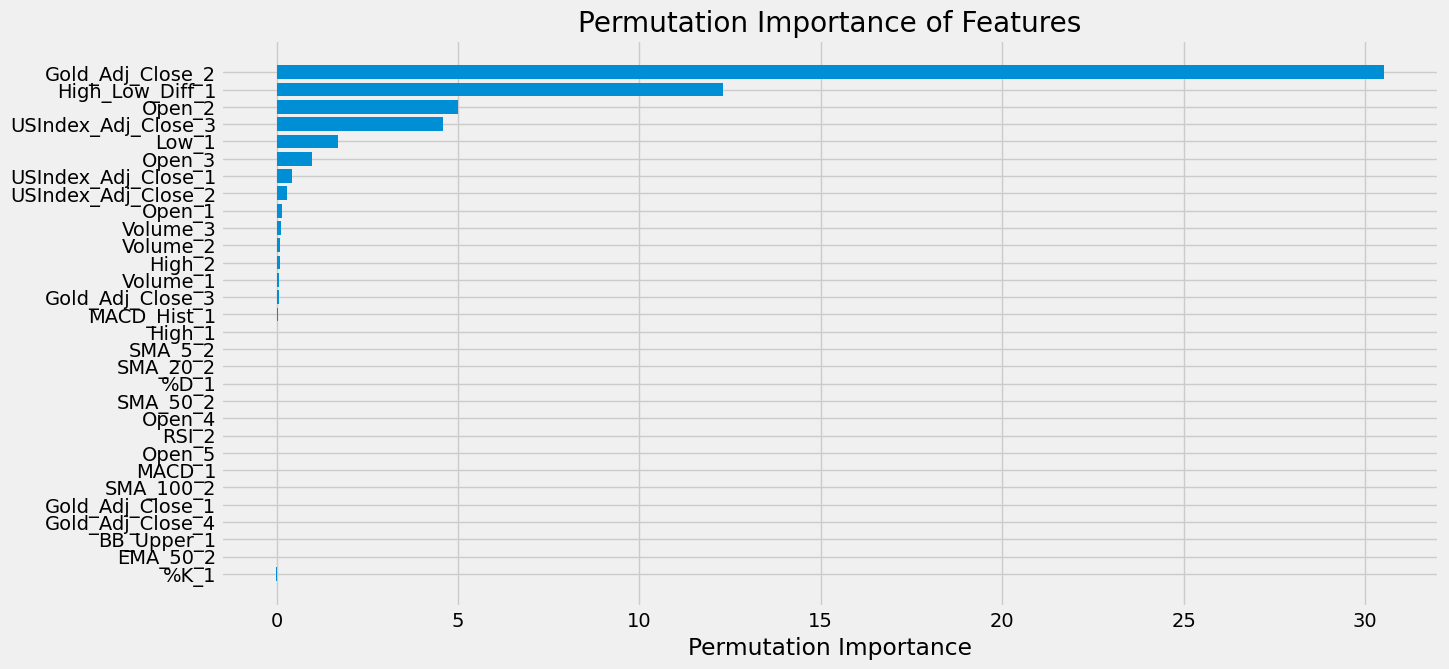

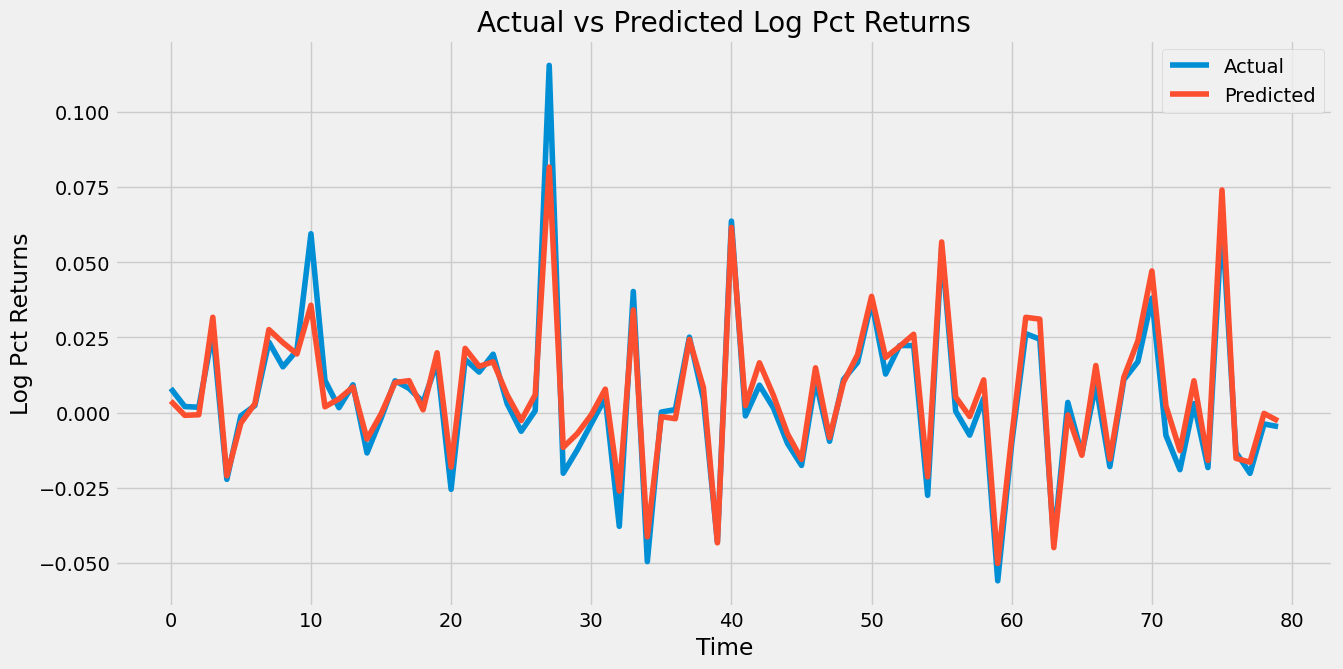

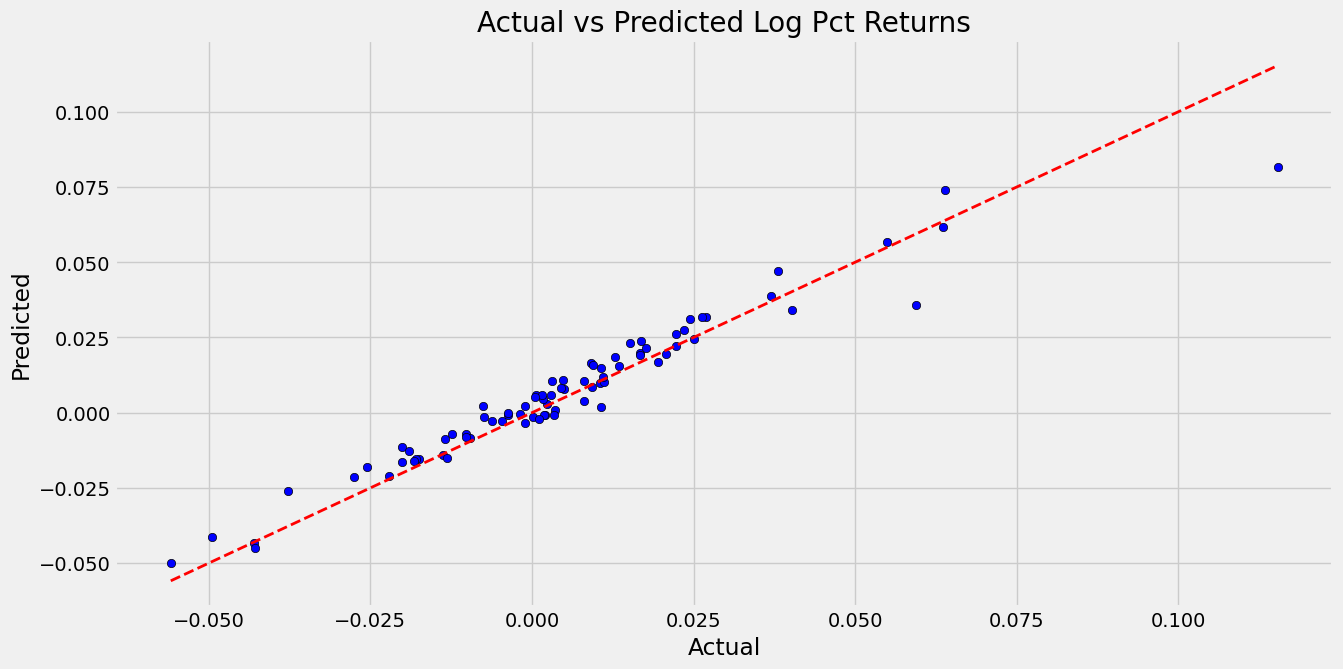

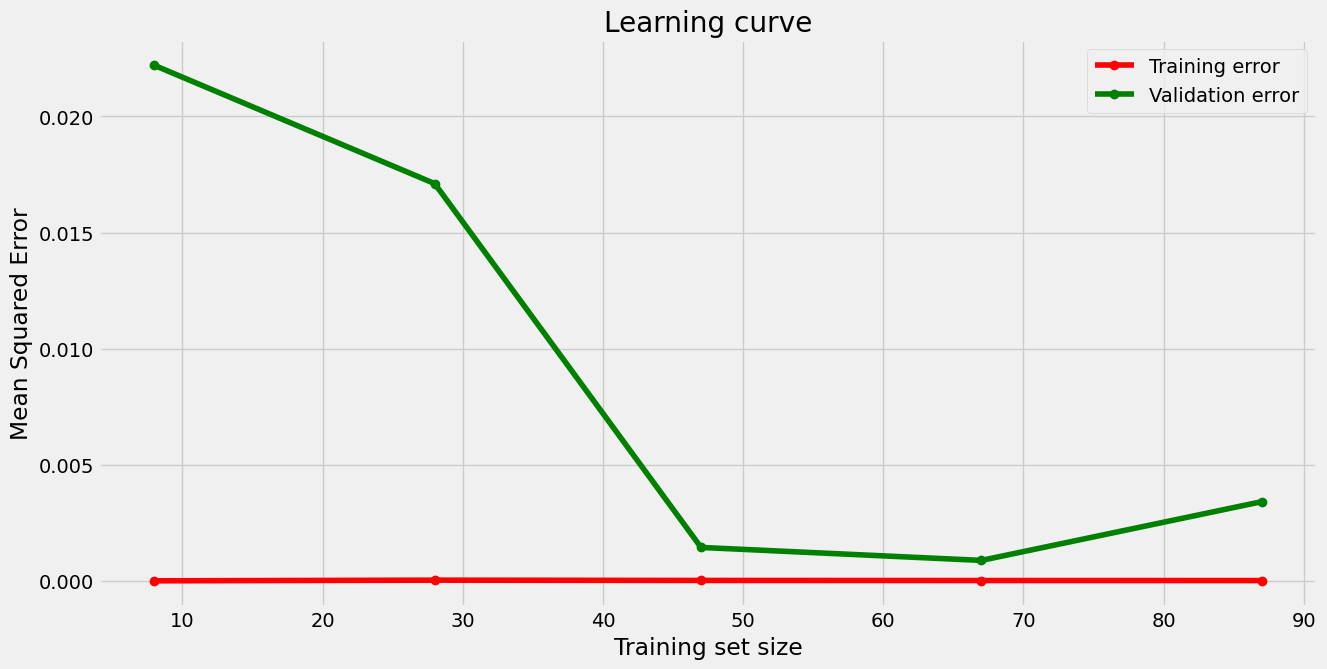

In [20]:
# Seed for reproducibility
np.random.seed(42)

features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 
             'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3',  
             'Gold_Adj_Close_3','USIndex_Adj_Close_3', 'Open_4', 
             'Gold_Adj_Close_4','Open_5','MACD_1',
            'MACD_Hist_1', 'BB_Upper_1', '%K_1', '%D_1',
            'SMA_5_2',  'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3',
            ]

X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply Recursive Feature Elimination (RFE)
estimator = Ridge()
rfe = RFE(estimator, n_features_to_select=30, step=1)
X_rfe = rfe.fit_transform(X, y)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_rfe)

# Define the range of alpha values to test
alpha_values = [1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0, 100.0]

# Create a parameter grid
param_grid = {'alpha': alpha_values}

# Initialize Ridge regression model
model = Ridge()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    model = grid_search.best_estimator_

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(14, 7))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(14,7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()


# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(14, 7))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

#### Hypertuning Gradient Boosting Regression Model

Selected Features: ['Volume_1' 'High_Low_Diff_1' 'Gold_Adj_Close_1' 'USIndex_Adj_Close_1'
 'Volume_2' 'High_Low_Diff_2' 'Gold_Adj_Close_2' 'USIndex_Adj_Close_2'
 'High_Low_Diff_3' 'USIndex_Adj_Close_3' 'Volume_4' 'Volume_5' 'SMA_10_1'
 'MACD_1' 'MACD_Hist_1' 'BB_Lower_1' '%K_1' '%D_1' 'SMA_20_2' 'RSI_2'
 'MACD_2' 'MACD_Hist_2' '%K_2' '%D_2' 'ATR_2' 'SMA_5_3' 'SMA_10_3'
 'SMA_20_3' 'RSI_3' 'MACD_3' 'MACD_Hist_3' '%K_3' '%D_3' 'ATR_3' 'RSI_4'
 'MACD_Hist_4' 'BB_Lower_4' '%K_4' 'SMA_10_5' 'SMA_50_5' 'RSI_5' 'MACD_5'
 'MACD_Hist_5' 'BB_Lower_5' '%K_5' '%D_5' 'ATR_5' 'WM2NS_1' 'UMCSENT_2'
 'PPIACO_2']
Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Gradient Boosting Results:
Training MSE: 0.0001 (Std Dev: 0.0000)
Test MSE: 0.0004 (Std Dev: 0.0003)
Training RMSE: 0.0073 (Std Dev: 0.0028)
Test RMSE: 0.0195 (Std Dev: 0.0079)
Training MAE: 0.0056 (Std Dev:

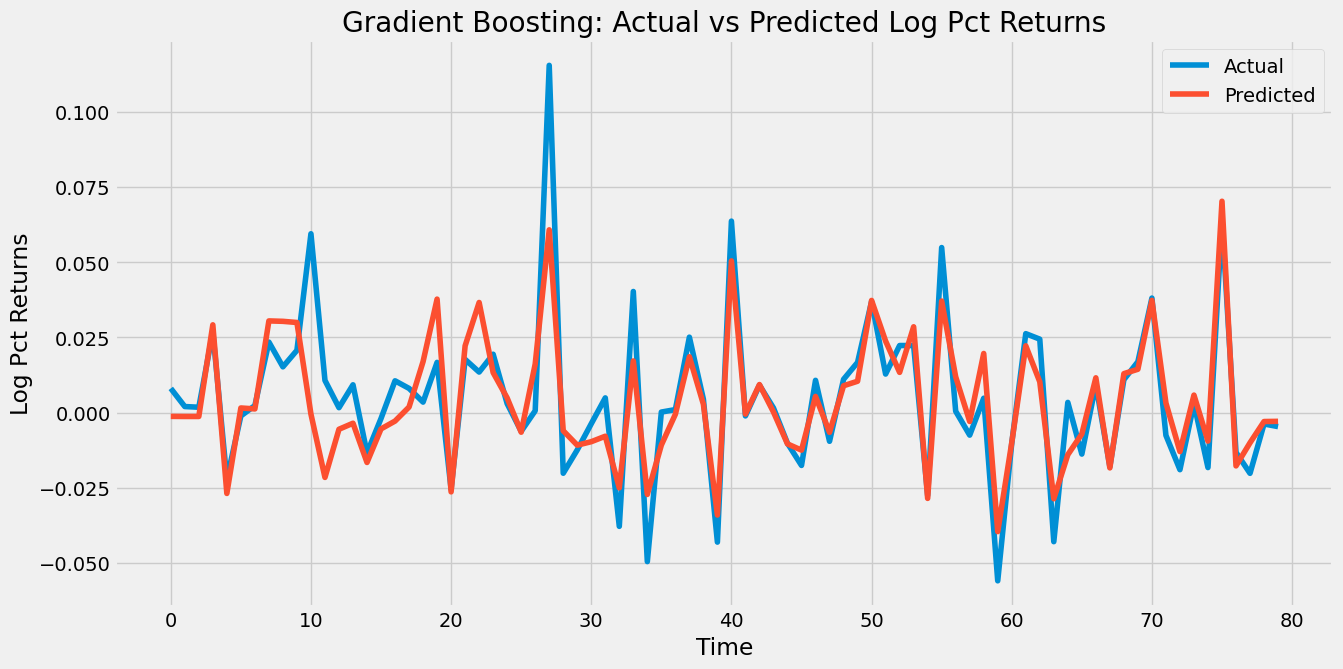

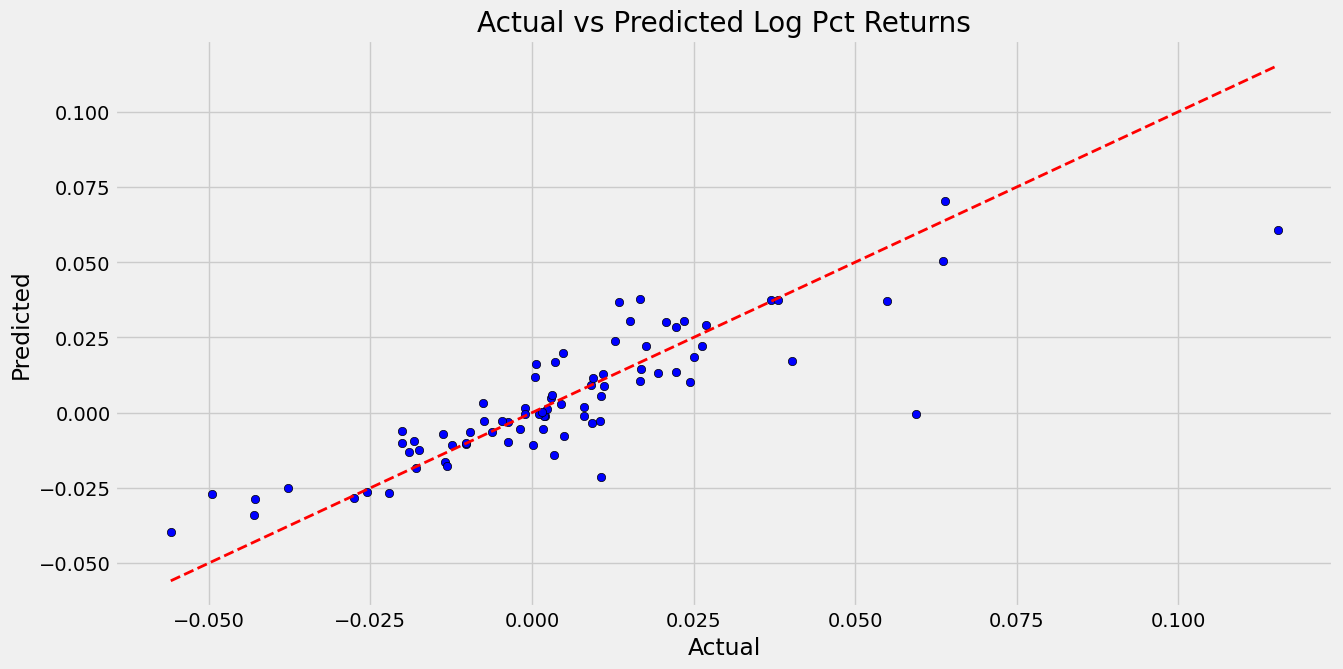

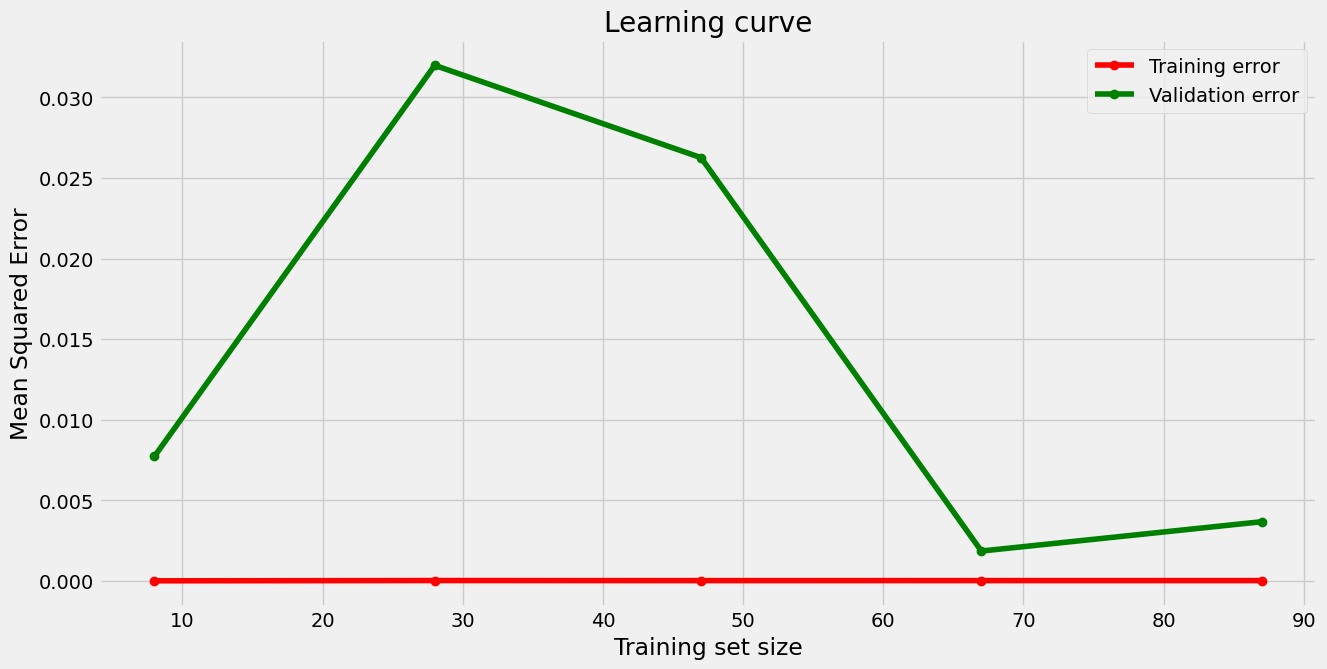

In [18]:
# Defining features for models
features = ['Volume_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 
            'High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3', 
            'Volume_4',  
            'High_Low_Diff_4', 'Gold_Adj_Close_4','USIndex_Adj_Close_4', 
            'Volume_5',  
             'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'SMA_5_4', 'SMA_10_4', 'SMA_20_4', 'SMA_50_4','SMA_100_4',
            'EMA_50_4', 'RSI_4', 'MACD_4', 'MACD_Signal_4',
            'MACD_Hist_4', 'BB_Upper_4', 'BB_Lower_4', '%K_4', '%D_4', 'ATR_4',
            'SMA_5_5', 'SMA_10_5', 'SMA_20_5', 'SMA_50_5','SMA_100_5',
            'EMA_50_5', 'RSI_5', 'MACD_5', 'MACD_Signal_5',
            'MACD_Hist_5', 'BB_Upper_5', 'BB_Lower_5', '%K_5', '%D_5', 'ATR_5',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3',
            'DSPIC96_4', 'FEDFUNDS_4', 'GDPC1_4', 'UNRATE_4', 
            'UMCSENT_4', 'CPILFESL_4', 'PPIACO_4', 'WM2NS_4',
            'DSPIC96_5', 'FEDFUNDS_5', 'GDPC1_5', 'UNRATE_5', 
            'UMCSENT_5', 'CPILFESL_5', 'PPIACO_5', 'WM2NS_5'
            ]
# Define your features X and target y
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize RFE
rfe = RFE(estimator=GradientBoostingRegressor(random_state=42), n_features_to_select=50)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Fit RFE
X_rfe = rfe.fit_transform(X_scaled, y)

# Get selected features
selected_features = np.array(features)[rfe.support_]
print("Selected Features:", selected_features)

# Update features and X_scaled with selected features
features = selected_features.tolist()
X_scaled = X_rfe

# Initialize Gradient Boosting regressor
model_gb = GradientBoostingRegressor(random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_gb, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=tscv, 
                           n_jobs=-1, verbose=1)

# Perform GridSearchCV to find the best model
grid_search.fit(X_scaled, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best Parameters:")
print(best_params)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    best_model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append scores to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Print Results
print("Gradient Boosting Results:")
print("Training MSE: {:.4f} (Std Dev: {:.4f})".format(mean_train_mse, std_train_mse))
print("Test MSE: {:.4f} (Std Dev: {:.4f})".format(mean_test_mse, std_test_mse))
print("Training RMSE: {:.4f} (Std Dev: {:.4f})".format(mean_train_rmse, std_train_rmse))
print("Test RMSE: {:.4f} (Std Dev: {:.4f})".format(mean_test_rmse, std_test_rmse))
print("Training MAE: {:.4f} (Std Dev: {:.4f})".format(mean_train_mae, std_train_mae))
print("Test MAE: {:.4f} (Std Dev: {:.4f})".format(mean_test_mae, std_test_mae))
print("Training R2: {:.4f} (Std Dev: {:.4f})".format(mean_train_r2, std_train_r2))
print("Test R2: {:.4f} (Std Dev: {:.4f})".format(mean_test_r2, std_test_r2))

# Visualize model performance
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Gradient Boosting: Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()


# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(14, 7))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()